In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v3 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

## Dataset(資料集解析)

y = 1. It's a cat picture.
train_x_orig.shape: (209, 64, 64, 3)

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)

train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


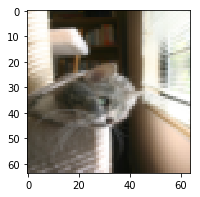

In [2]:
# Load dataset.
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()
# Example of a picture
index = 166
plt.figure(num=1, figsize=(3,3))
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]
print ("train_x_orig.shape: " + str(train_x_orig.shape))
print("")
print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print("")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

As usual, you reshape and standardize the images before feeding them to the network. The code is given in the cell below.
<img src="images/BP_Tutorial_03_input_pictures.png" style="">

<caption><center> <u>Figure 1</u>: Image to vector conversion. <br> </center></caption>

In [3]:
# Preprocess input data(images)
# Reshape the training and test examples
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


## N-layer Logistic Regression model(N層邏輯回歸模型解說)
Now we talk about the 4-layer architecture logistic regression model. There are two computation graph for 4-layer and N-layer backpropagation below. We hope that can help you understand how it works and how can we design the program.
At first, we have to understand how the 4-layer BP pass the parameters and compute the gradients, it's very helpful to realize the computation process of N-layer backpropagation.

### 4-layer neural network computation flow

<img src="images/BP_Tutorial_03_BP_computation_flow.png" style="width:950px;height:auto;">
<caption><center> <u>Figure 2</u>: 4-layer neural network computation flow.</center></caption>

<u>Detailed computation flow of figure 2</u>:
#### Forward pass
- Each of the inputs data is a $(64,64,3)$ image which is flattened to a vector of size $(12288,1)$. The Fig.1 shows the flattening process and concepts.
- The superscript [1] means the first layer of this model. It's also the first layer of backpropagation.
- In this 4-layer model, we set the number of neurons from layer-1 to layer-4 corresponds as 20, 7, 5, 1. And we call the input-layer as the 0-layer. The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ of size $(20, 12288)$. You then add a bias term $b^{[1]}$ and get the vector $Z^{[1]}$.
- You then take $Z^{[1]}$ into activation function **ReLU** to get the following vector: $A^{[1]}=[a_0^{[1]}, a_1^{[1]},..., a_{19}^{[1]}]^T$ and the shape of $A^{[1]}$ should be $(20, 209)$.
- You then repeat the same process until you complete the calculation of layer-3.
- The calculation of layer-4 basically is the same as the former 3 layers, but the activation function replaced with **Sigmoid**.
- Finally, you take the sigmoid of the result. If it is greater than 0.5, you classify it to be a cat.
- The variable *Linear_cahce*, *Activation_cache* are the type of Python dictionary. The purpose of these two variables is to cache the variables that will be used in the **backward pass**.

#### Backward pass
- As you can see the RED words in Fig.2, that means this variables are cached from the **forward pass**.
- All you can do is to follow the chain rule to compute the gradients values of $W, b$ in each layer.
- Finally, you can update all the parameters in the model.
- We do not add the input data block and the update parameters block into Fig.2 is because of the limitation of the image width. Because of for-loop reduces the contents in the figure, therefore, we add these blocks back into Fig.3.

### N-layer neural network computation flow

<img src="images/BP_Tutorial_03_BP_N-layer_computation_flow.png" style="width:950px;height:auto;">
<caption><center> <u>Figure 3</u>: N-layer neural network computation flow.</center></caption>

#### Concepts
- The for-loop can handle the computation from layer-1 to layer-(N-1). So that we only need is to find the computing rules between the adjacent layers.

## Initialize parameters(初始化參數)

In [4]:
def NL_initialize_parameters(layer_dims):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    parameters -- python dictionary containing your parameters:
    
                    W1 -- weight matrix of shape (Layer_dims[W1], Layer_dims[W0])
                    b1 -- bias vector of shape (Layer_dims[W1], 1)
                    W2 -- (Layer_dims[W2], Layer_dims[W1])
                    b1 -- (Layer_dims[W2], 1)
                    
                    So we can get these rule: ("L" denotes the number of layer.)
                    Shape of "WL" -- (Layer_dims[L], Layer_dims[L-1])
                    Shape of "bL" -- (Layer_dims[L], 1)
    """
    np.random.seed(1)
    parameters = {}
    Layers = len(layer_dims)
    
    for l in range(1, Layers):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
    
    return parameters

## Forward pass(正向傳遞)

In [5]:
def NL_forwardpass(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-2)
                the cache of linear_sigmoid_forward() (there is one, indexed L-1)
    """
    
    caches = []
    A = X
    L = len(parameters) // 2  
    linear_cache = {}
    activation_cache = {}
    
    for l in range(1, L):
        linear_cache = {}
        activation_cache = {}
        A_prev = A
        W = parameters['W' + str(l)]
        b = parameters['b' + str(l)]
        
        # Linear calculation
        linear_cache["A_prev" + str(l)] = A_prev
        linear_cache["W" + str(l)] = W
        linear_cache["b" + str(l)] = b
        Z = W.dot(A_prev) + b
        
        # ReLU calculation: ReLU
        A = np.maximum(0, Z)
        activation_cache["Z" + str(l)] = Z
        cache = (linear_cache, activation_cache)
        caches.append(cache)
    
    ## The final layer.
    linear_cache = {}
    activation_cache = {}
    W = parameters['W' + str(L)]
    b = parameters['b' + str(L)]
    
    # Linear calculation
    linear_cache["A_prev" + str(L)] = A
    linear_cache["W" + str(L)] = W
    linear_cache["b" + str(L)] = b
    ZL = W.dot(A) + b
    
    # Activative calculation: Sigmoid
    AL = 1/(1+np.exp(-ZL))
    activation_cache["Z" + str(L)] = ZL
    
    
    cache = (linear_cache, activation_cache)
    caches.append(cache)
    
    
    assert(AL.shape == (1,X.shape[1]))
    
    return AL, caches

## Compute Cost(計算成本)
Now that you have computed $A^{[N]}$ (in the Python variable "`AL`"), which contains $a^{[N](i)}$ for every example, you can compute the cost function as follows:
(Variable $m$ means the number of input pictures.)
$$L = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large{(} \small y^{(i)}\log\left(a^{[N] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[N] (i)}\right) \large{)} \small$$


In [12]:
def compute_cost(AL, Y):
    m = Y.shape[1]   # number of calss

    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    
    cost = np.squeeze(cost)  # makes sure cost is the dimension we expect.
    return cost

## Backward pass(反向傳遞)
Using the cache computed during forward propagation, you can now implement backward propagation. You can look back to the **Fig.3** to understand how it works.

In [7]:
def NL_backwardpass(AL, X, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (there are (L-1) or them, indexes from 0 to L-2)
                the cache of linear_activation_forward() with "sigmoid" (there is one, index L-1)
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    ## Initializing the backpropagation
    ## Computes the gradient of AL. (AL means the y-hat of model.)
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    ## L-th layer gradients.
    ## (Sigmoid -> Linear)
    current_cache = caches[L-1]   # The index of caches is in the range of 0 to L-1.
    linear_cache, activation_cache = current_cache
    
    # dZL (Sigmoid backward)
    s = 1/(1+np.exp( -activation_cache["Z" + str(L)] ))
    dZL = dAL * s * (1-s)
    
    # dA_prev (Linear backward)
    A_prev = linear_cache["A_prev" + str(L)]
    W = linear_cache["W" + str(L)]
    b = linear_cache["b" + str(L)]
    m = A_prev.shape[1]
    dW = 1./m * np.dot(dZL, A_prev.T)
    db = 1./m * np.sum(dZL, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZL)

    ## Save grads.(The L-th layer)
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = dA_prev, dW, db
    
    ## The value of l is decreased from L-1 to 1.
    for l in reversed(range(1, L)):
        ## l-th layer gradients.
        ## (ReLU -> Linear), Example: caches[2] contains: A_prev3, W3, b3
        current_cache = caches[l-1]
        linear_cache, activation_cache = current_cache
    
        # dZ (ReLU backward)
        Z = activation_cache["Z" + str(l)]
        dZ = np.array(grads["dA" + str(l)], copy=True)
        dZ[Z<=0] = 0
        assert (dZ.shape == Z.shape)  # check shape
        
        # dA (Linear backward)
        A_prev = linear_cache["A_prev" + str(l)]
        W = linear_cache["W" + str(l)]
        b = linear_cache["b" + str(l)]
        m = A_prev.shape[1]
        dW = 1./m * np.dot(dZ,A_prev.T)
        db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
        dA_prev = np.dot(W.T,dZ)
        assert (dA_prev.shape == A_prev.shape)  # check shape
        assert (dW.shape == W.shape)
        assert (db.shape == b.shape)
        
        ## Save grads.(the l-th layer)
        grads["dA" + str(l-1)], grads["dW" + str(l)], grads["db" + str(l)] = dA_prev, dW, db
    
    return grads

## Update parameters(更新參數)

In [8]:
def update_parameters(parameters, grads, learning_rate = 1.2):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network
    
    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
    
    return parameters

## Main program(主程式)
- 1.Initialize parameters -> 2.Forward pass -> 3.Compute cost -> 4.Backward pass ->  5.Update parameters
- Repeats the step-2 to step-5 until the end of the iteration.

In [14]:
def NL_nn_model(X, Y, layers_dims, num_iterations = 5000, learning_rate=0.08, print_cost = False):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    layers_dims -- size of all the hidden layers
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    costs = []
    np.random.seed(1)
    
    # Initialize W, b
    parameters = NL_initialize_parameters(layers_dims)
    
    for i in range(0, num_iterations):
        # Forward pass
        AL, caches = NL_forwardpass(X, parameters)
        
        # Compute cost
        cost = compute_cost(AL, Y)

        # Backward pass
        grads = NL_backwardpass(AL, X, Y, caches)
        
        # Update parameters
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Print the cost so far every 500 iterations
        if i % 500 == 0:
            costs.append(cost)
            if print_cost:
                print("Cost after iteration {}: {}".format(i, cost))
    
    # Append the cost of final layer into "costs".
    costs.append(cost)
    plt.figure(num=1, figsize=(8,5))
    plt.semilogy(costs)
    plt.xlabel("Iterations")
    plt.ylabel("Cost")
    plt.title("Learning Rate = " + str(learning_rate))
    plt.show()

    return parameters

## Predict(預測)

In [10]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = NL_forwardpass(X, parameters)

    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

## How to operate this model? (如何使用)
### Set the training parameters. (訓練參數)

Cost after iteration 0: 0.7717493284237686
Cost after iteration 500: 0.5886584839383819
Cost after iteration 1000: 0.30927866900166645
Cost after iteration 1500: 0.1751227574755695
Cost after iteration 2000: 0.10692344962666668
costs: [array(0.77174933), array(0.58865848), array(0.30927867), array(0.17512276), array(0.10692345), array(0.08282594)]


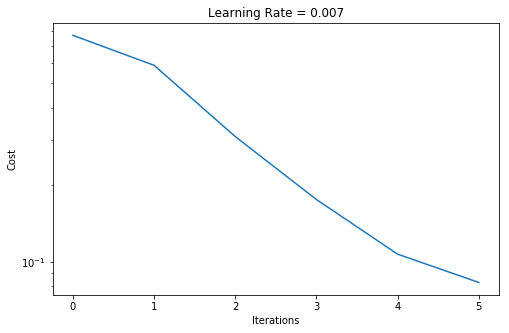

In [13]:
layers_dims = [12288, 20, 7, 5, 1] # 4-Layer model
parameters = NL_nn_model(train_x, train_y, layers_dims, num_iterations=2500, learning_rate=0.007, print_cost=True)

### Compute the prediction accuracy(精準度判斷)

In [15]:
print("Training accuracy:")
predictions_train = predict(train_x, train_y, parameters)
print("Testing accuracy:")
predictions_test = predict(test_x, test_y, parameters)

Training accuracy:
Accuracy: 0.9952153110047846
Testing accuracy:
Accuracy: 0.8200000000000001


### Find a image(自己找一張圖測試)

Accuracy: 1.0
y = 1.0, your L-layer model predicts a "cat" picture.


/home/andy/anaconda3/envs/numpy/lib/python3.5/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  
/home/andy/anaconda3/envs/numpy/lib/python3.5/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if __name__ == '__main__':


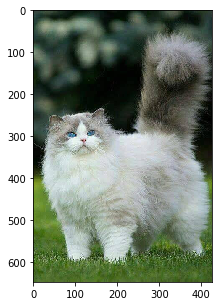

In [16]:
## START CODE HERE ##
# cat.jpg  my_image.jpg  people.jpeg
my_image = "my_image2.jpg" # change this to the name of your image file 
my_label_y = [1] # the true class of your image (1 -> cat, 0 -> non-cat)
## END CODE HERE ##

fname = "images/" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((num_px*num_px*3,1))
my_image = my_image/255.
my_predicted_image = predict(my_image, my_label_y, parameters)

plt.figure(num=1, figsize=(5,5))
plt.imshow(image)
print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

### Show the incorrect predicting image(找出錯誤的圖片)

In [17]:
def print_mislabeled_images(classes, X, y, p):
    """
    Plots images where predictions and truth were different.
    X -- dataset
    y -- true labels
    p -- predictions
    """
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))

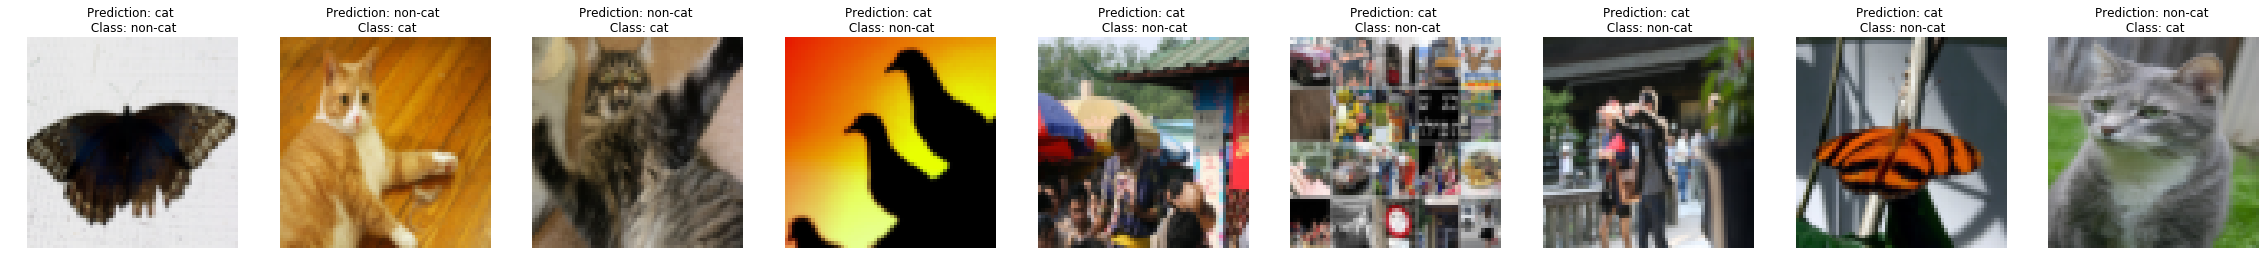

In [18]:
print_mislabeled_images(classes, test_x, test_y, predictions_test)